In [1]:
import os
import xarray as xr
import numpy as np
from pathlib import Path
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import logger
import xesmf as xe
from scipy.ndimage import label

import climtas.nci
from dask.distributed import Client, as_completed

In [6]:
LOG = logger.get_logger(__name__)

In [19]:
directory=Path(f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1d/v1.1/2025/01/01')
file = sorted(str(p) for p in directory.rglob("*.nc"))[0]

himawari = xr.open_dataset(file)

In [23]:
himawari

<xarray.Dataset> Size: 183MB
Dimensions:                                       (time: 1, latitude: 1726,
                                                   longitude: 2214,
                                                   n_possible_obs: 103)
Coordinates:
  * time                                          (time) datetime64[ns] 8B 20...
  * latitude                                      (latitude) float32 7kB -44....
  * longitude                                     (longitude) float32 9kB 112...
Dimensions without coordinates: n_possible_obs
Data variables:
    crs                                           int32 4B ...
    input_file_available                          (n_possible_obs) int32 412B ...
    daily_integral_of_surface_global_irradiance   (time, latitude, longitude) float64 31MB ...
    daily_integral_of_direct_normal_irradiance    (time, latitude, longitude) float64 31MB ...
    daily_integral_of_surface_diffuse_irradiance  (time, latitude, longitude) float64 31MB ...
    number_of_observations                        (time, latitude, longitude) float64 31MB ...
    number_of_cloud_observations                  (time, latitude, longitude) float64 31MB ...
    quality_mask                                  (time, latitude, longitude) float64 31MB ...
Attributes: (12/55)
    Conventions:                     CF-1.7
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    acknowledgment:                  The following acknowledgement is require...
    cdm_data_type:                   grid
    comment:                         Solar radiation data derived from satell...
    contributor_name:                Mines ParisTech; Commonwealth of Austral...
    ...                              ...
    source:                          IDE00326.202412311830.nc [uuid: bfd812e4...
    uuid:                            37ab0599-d591-4026-bea9-bdc0c3b4ac71
    date_created:                    20250325T053415Z
    quality:                         0
    quality_meaning:                 0: no_known_issues 1: medium 2: low 4: poor
    history:                         heliosat-4; post_process_p1s.py, post_pr...

In [98]:
def drought_metrics(date):

    date_dt = datetime.strptime(date, "%m-%Y")
    year = date_dt.strftime("%Y")
    month = date_dt.strftime("%m")
    
    ##### Himawari Data
    if date_dt <= datetime.strptime('2019-03-31', '%Y-%m-%d'):
        version = 'v1.0'
    else:
        version = 'v1.1'
    directory=Path(f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1d/{version}/{year}/{month}')
    files = sorted(str(p) for p in directory.rglob("*.nc"))
    def _preprocess(ds):
        return ds.drop_vars(set(ds.data_vars) - {'daily_integral_of_surface_global_irradiance'})
    
    himawari = xr.open_mfdataset(
        files,
        combine='by_coords',
        preprocess=_preprocess,
        # engine='netcdf4',
    )
    LOG.info('OPEN HIMAWARI')
    himawari = himawari.chunk({'time':-1})

    threshold = 0.6
    data = himawari.daily_integral_of_surface_global_irradiance
    mean = data.mean(dim='time')
    droughts = data < (threshold * mean)

    _MAX_EVENTS = 100
    # Get drought lengths
    def compute_durations(da):
        labels, num = label(da)
        durations = np.array([(labels == i).sum() for i in range(1, num + 1)], dtype=np.int32)
        padded = np.full((_MAX_EVENTS,), fill_value=np.nan, dtype=np.float32)
        padded[:len(durations)] = durations[:_MAX_EVENTS]
        return padded
    
    # Step 3: Apply function along 'time' axis using apply_ufunc
    durations = xr.apply_ufunc(
        compute_durations,
        droughts,
        input_core_dims=[['time']],
        output_core_dims=[['event']],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[np.float32],
        output_sizes={'event': _MAX_EVENTS},  # this fixes the ValueError
    )
    '''
    HWD
    '''
    return durations.max(dim='event', skipna=True)
    '''
    HWN
    '''
    # return droughts.sum(dim='time')
    '''
    HWM
    '''
    # drought_data = xr.where(data < (threshold * mean), data, np.nan)
    # return drought_data.mean(dim='time', skipna=True)
    '''
    HWA
    '''
    return data.min(dim='time')

In [86]:
# Step 1: Create binary mask
data = [0,1,1,1,1,0,1,1,0,1,0,0,0,1,1,1, 0, 1, 0, 1, 0, 1, 1, 1]
time= np.linspace(1,len(data), len(data))
my_da = xr.DataArray(data, coords={'time':time})

# Step 2: Function to compute durations along 1D time axis
def compute_durations(mask_1d):
    labels, num = label(mask_1d)
    return np.array([(labels == i).sum() for i in range(1, num + 1)], dtype=np.int32)

# Step 3: Apply function along 'time' axis using apply_ufunc
durations = xr.apply_ufunc(
    compute_durations,
    my_da,
    input_core_dims=[['time']],
    output_core_dims=[['event']],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[np.int32],
)

In [3]:
client = Client(
    n_workers=10,
    threads_per_worker=1
)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 10
Total threads: 10,Total memory: 95.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44381,Workers: 10
Dashboard: /proxy/8787/status,Total threads: 10
Started: Just now,Total memory: 95.00 GiB
Comm: tcp://127.0.0.1:46419,Total threads: 1
Dashboard: /proxy/46601/status,Memory: 9.50 GiB
Nanny: tcp://127.0.0.1:36127,


In [99]:
if __name__ == '__main__':
    futures = {}
    for month in range(1,2):
        date = f'{month}-2016'
        future = client.submit(drought_metrics, date)
        futures[future] = f"The job for {date}"
    for future in as_completed(futures):
        metric = future.result()

INFO:__main__:OPEN HIMAWARI
/jobfs/142400431.gadi-pbs/ipykernel_2448680/4212652799.py:41: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.


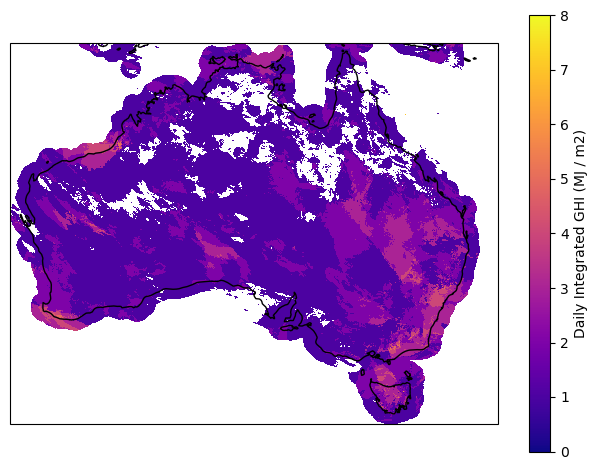

In [100]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

latitudes = metric.latitude
longitudes = metric.longitude
irradiance = metric.values

# Create a figure
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

mesh=ax.pcolormesh(longitudes, latitudes, irradiance, cmap='plasma',vmin=0,  transform=ccrs.PlateCarree())

ax.coastlines()
cbar = plt.colorbar(mesh,ax=ax)
# cbar.ax.tick_params(labelsize=5)  # Set the font size for the colorbar ticks
cbar.set_label('Daily Integrated GHI (MJ / m2)') 
 
plt.tight_layout()

plt.show()